# Twitter Sentiment Analysis

Steps:
1) Importing Libraries & Packages
2) Importing Dataset
3) Preprocessing Text
4) Analsis the Text
5) Splitting The Data
6) TF-IDF Vectorizer
7) Transforming Dataset
8) Create & Evaluate Model
9) Saving the Models & Using the model

### Step-1: Importing Libraries & Packages

In [24]:
#utilities
import re
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

#plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/preetish/nltk_data...


### Step-2: Importing Dataset

In [31]:
dfcolumns=['sentiment','id','date','flag','user','text']
dataset = pd.read_csv('/Users/preetish/Downloads/training.1600000.processed.noemoticon.csv', names=dfcolumns, encoding='latin-1')

dataset=dataset[['sentiment','text']]
dataset['sentiment']=dataset['sentiment'].replace(4,1)


text,sentiment=list(dataset['text']),list(dataset['sentiment'])
dataset.head(5)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

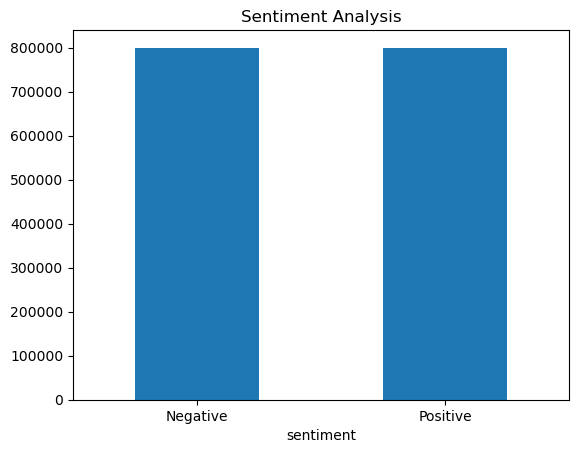

In [33]:
# Plotting the distribution for dataset

ax=dataset.groupby('sentiment').count().plot(kind='bar',title='Sentiment Analysis',legend=False)
ax.set_xticklabels(['Negative','Positive'],rotation=0)

### Step-3: Preprocess Text

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [35]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [37]:
def preprocess(textdata):
    processedText = []
    
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        tweet = re.sub(urlPattern,' URL',tweet)

        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        

        tweet = re.sub(userPattern,' USER', tweet)        

        tweet = re.sub(alphaPattern, " ", tweet)

        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if word not in stopwordlist:
                if len(word)>1:
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [39]:
import time
t=time.time()
processedText=preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 51 seconds


### Step-4: Analysing the data

We will plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

### Word-Cloud for Negative tweets

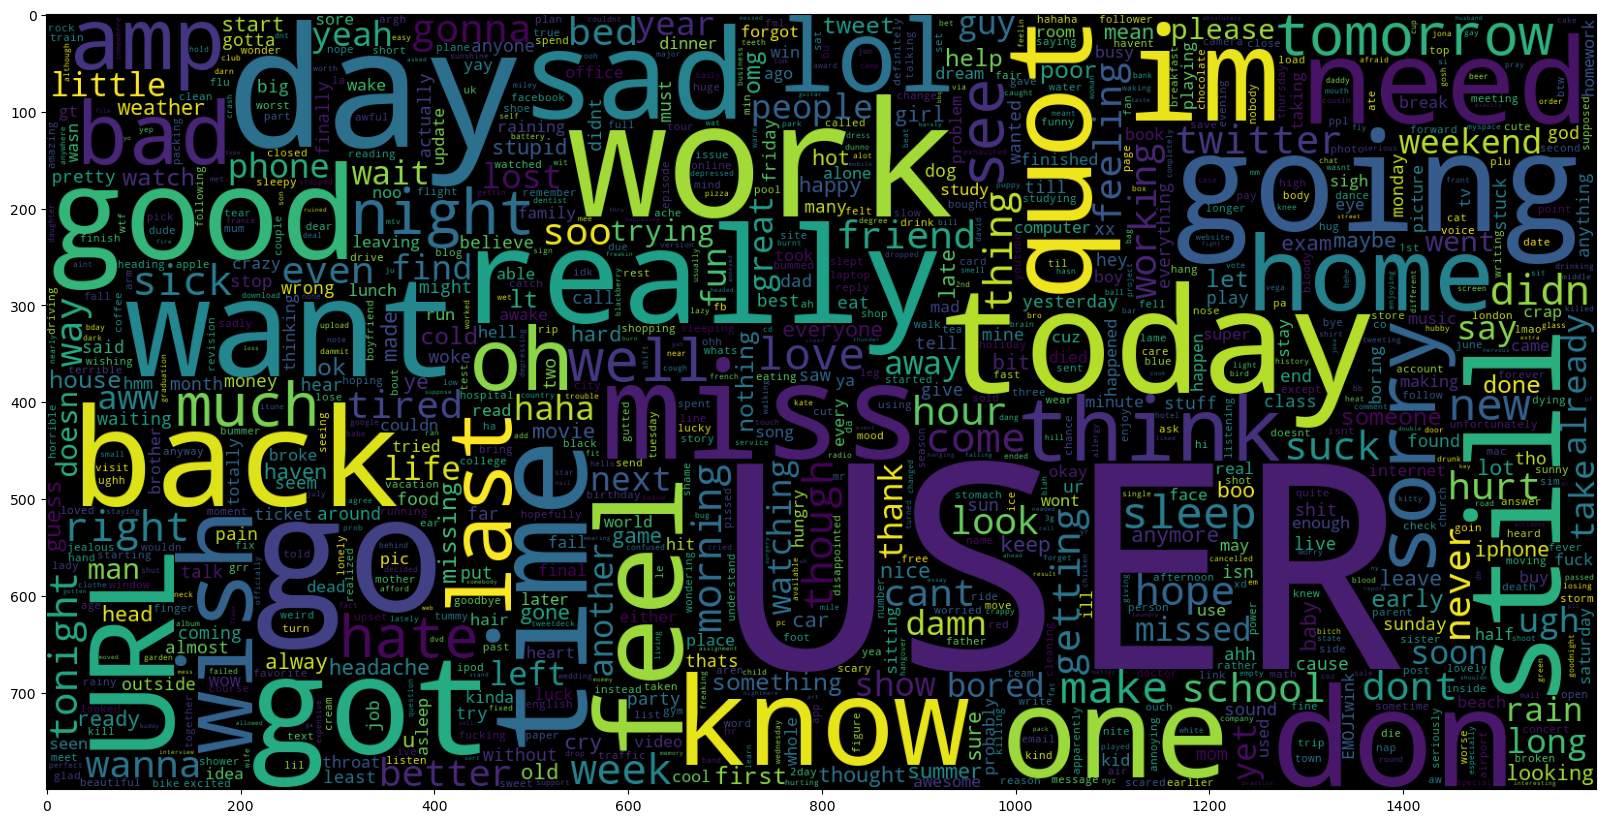

In [42]:
negative=processedText[:800000]
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=1000,width=1600,height=800,
             collocations=False).generate(" ".join(negative))
plt.imshow(wc)

### Word-Cloud for Positive tweets.

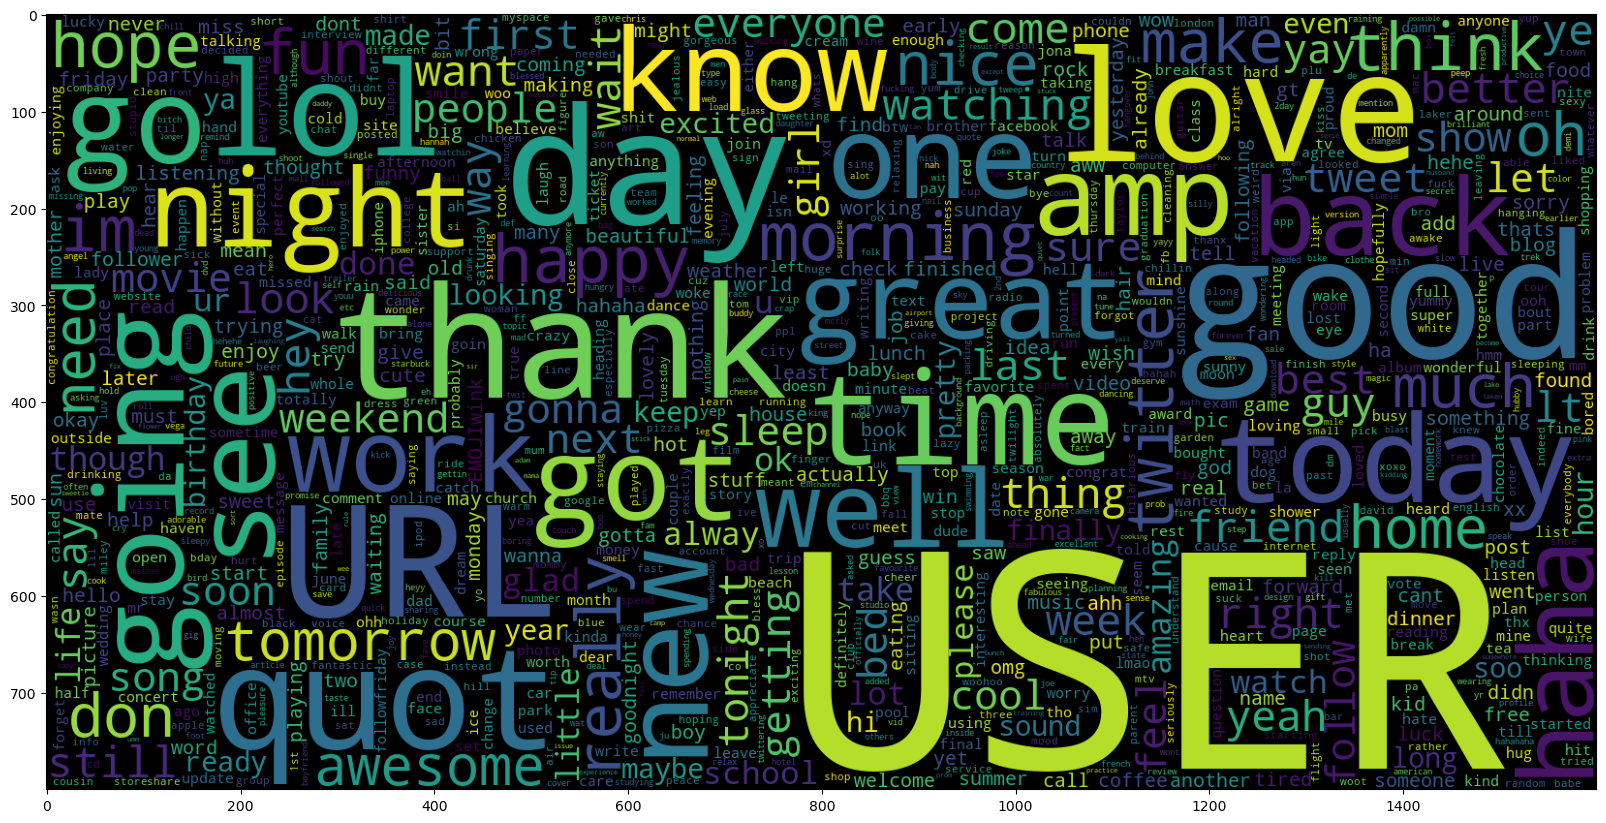

In [44]:
positive=processedText[800000:]
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=1000,width=1600,height=800,
             collocations=False).generate(" ".join(positive))
plt.imshow(wc)

### Step-5: Splitting The Data

In [46]:
x_train,x_test,y_train,y_test=train_test_split(processedText,sentiment,test_size=0.20,random_state=0)

In [47]:
vectoriser=TfidfVectorizer(ngram_range=(1,2),max_features=500000)
vectoriser.fit(x_train)
print(f'No. of feature_words: {len(vectoriser.get_feature_names_out())}')

No. of feature_words: 500000


### Step-6: Transform The Data

In [49]:
x_train=vectoriser.transform(x_train)
x_test=vectoriser.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


### Step-6: Create and Evaluate Models

I used Four machine learning models:
1. Naive Bayes - MultinomialNB, Bernoulli
2. Support Vector Machines - LinearSVC
3. Logistic Regression


In [51]:
def EvaluationModel(model,name):
    y_pred=model.predict(x_test)
    print(classification_report(y_test,y_pred))

    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy=accuracy_score(y_test,y_pred)
    all_models_accuracy_score[name]=round(accuracy*100,2)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title (f"Confusion Matrix - {name}", fontdict = {'size':18}, pad = 20)

all_models_accuracy_score={}


### 1.MultinomialNB

              precision    recall  f1-score   support

           0       0.79      0.80      0.80    159815
           1       0.80      0.79      0.79    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

Time: 0.84 seconds


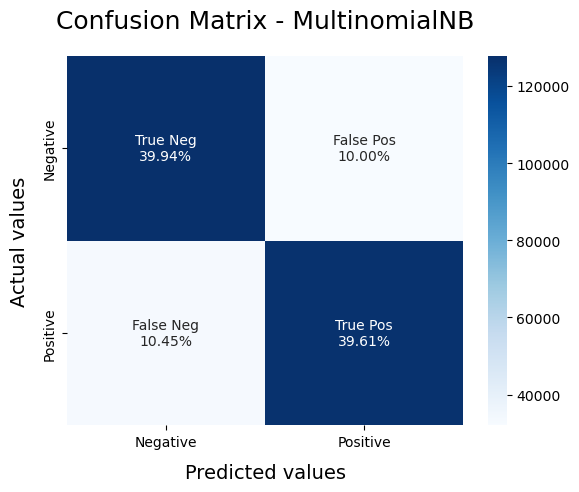

In [53]:
mb=MultinomialNB(alpha=1.0)
start=time.time()
mb.fit(x_train,y_train)
EvaluationModel(mb,"MultinomialNB")
end=time.time()
print(f'Time: {end-start:.2f} seconds')

### 2.BernouliNB Model

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159815
           1       0.79      0.81      0.80    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

Time: 0.76 seconds


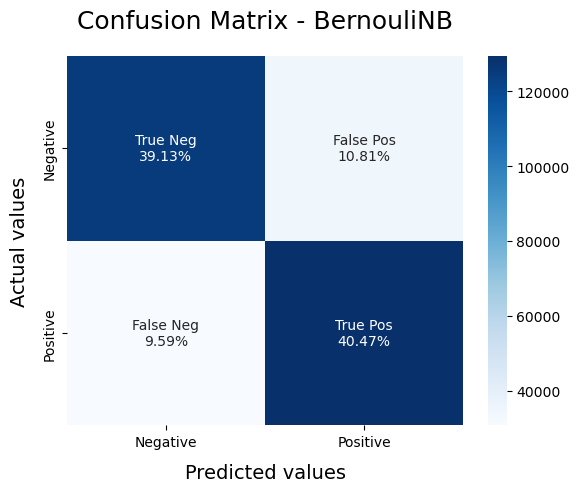

In [55]:
BNBmodel = BernoulliNB(alpha = 2)
start=time.time()
BNBmodel.fit(x_train, y_train)
EvaluationModel(BNBmodel,"BernouliNB")
end=time.time()
print(f'Time: {end-start:.2f} seconds')

### 3.Support Vector Machine

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159815
           1       0.79      0.81      0.80    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

Time: 16.19 seconds


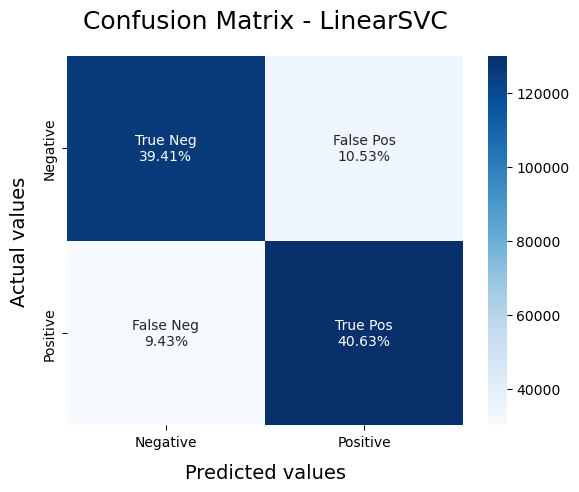

In [57]:
SVCmodel = LinearSVC()
time.time()
SVCmodel.fit(x_train, y_train)
EvaluationModel(SVCmodel,"LinearSVC")
end=time.time()
print(f'Time: {end-start:.2f} seconds')

### 4.Logistic Regression

              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159815
           1       0.81      0.82      0.81    160185

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000

Time: 19.03 seconds


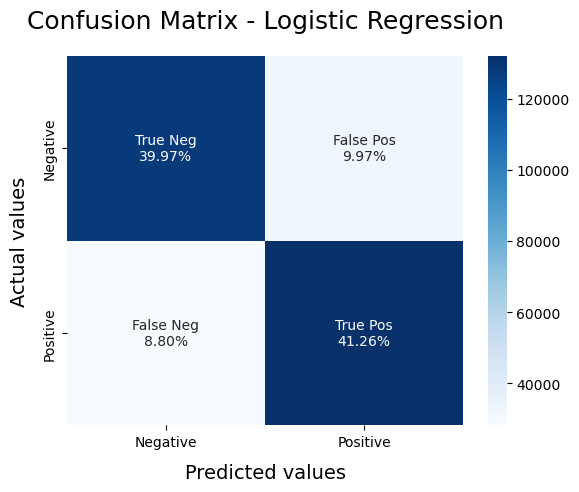

In [59]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
start=time.time()
LRmodel.fit(x_train, y_train)
EvaluationModel(LRmodel,"Logistic Regression")
end=time.time()
print(f'Time: {end-start:.2f} seconds')

In [60]:
for i,j in all_models_accuracy_score.items():
    print(f"{i} {j}")

MultinomialNB 79.55
BernouliNB 79.6
LinearSVC 80.04
Logistic Regression 81.23


### Step-7: Saving the Models

In [62]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

### Step-8: Using the Models

In [77]:
def load_model():
    file=open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser=pickle.load(file)
    file.close()

    file=open('Sentiment-LR.pickle','rb')
    LRmodel=pickle.load(file)
    file.close()

    return vectoriser,LRmodel

def predict(vectoriser,model,text):
    tweets=vectoriser.transform(preprocess(text))
    sentiment=model.predict(tweets)

    data = []
    for txt, pred in zip(text, sentiment):
        data.append((txt,pred))
        
    # Convert the list into a Pandas DataFrame.
    TweetsFrame = pd.DataFrame(data, columns = ['text','sentiment'])
    TweetsFrame = TweetsFrame.replace([0,1], ["Negative","Positive"])
    return TweetsFrame

vectoriser,LRmodel=load_model()
text_data = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
TweetsFrame=predict(vectoriser,LRmodel,text_data)
print(TweetsFrame.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative
